In [123]:
# Imports
from shapely.ops import nearest_points
import geopandas as gpd
import pyproj
from shapely.geometry import Polygon, LineString, Point, MultiLineString
from shapely.ops import transform, polygonize, unary_union
import matplotlib.pyplot as plt
from pyproj import Geod
import math
import numpy as np
import json
import pandas as pd

In [101]:
# DEFINE USEFUL FUNCTIONS

def get_utm_zone(lon):
    print(lon)
    return int((lon + 180) // 6) + 1

def get_utm_proj(lon, lat):
    print(lon)
    utm_zone = get_utm_zone(lon)
    is_northern = lat >= 0  # Determine if the zone is in the northern hemisphere
    return f"+proj=utm +zone={utm_zone} +{'north' if is_northern else 'south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"

# Simplified function to convert a distance in degrees to meters
def degrees_to_meters(distance_in_degrees, utm_proj_rectangle):
    
    # Create transformers for a small unit distance in degrees (1 degree) to meters
    transformer = pyproj.Transformer.from_crs("EPSG:4326", utm_proj_rectangle, always_xy=True)
    
    # Convert 1 degree distance to meters (latitude = 0 because we assume small distance near the UTM zone)
    lon1, lat1 = 0, 0
    lon2, lat2 = 1, 0
    
    x1, y1 = transformer.transform(lon1, lat1)
    x2, y2 = transformer.transform(lon2, lat2)
    
    # Calculate the distance in meters for 1 degree of longitude
    meters_per_degree = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    
    # Convert the input distance in degrees to meters
    distance_in_meters = distance_in_degrees * meters_per_degree
    
    return distance_in_meters

def calculate_area_geodesic(rectangle):
    # Create a Geod object for geodesic calculations
    geod = Geod(ellps="WGS84")

    # Calculate the area using the geod object. The area is returned in square meters.
    area, _ = geod.geometry_area_perimeter(rectangle.geometry[0])

    return abs(area)

In [105]:
# Read needed files: rectangle, buildings, streets

tile_id = 1
rectangles = gpd.read_file('./data/rectangles.geojson')
rectangle = rectangles[rectangles.n==tile_id]
rectangle_centroid = rectangle.geometry[0].centroid
utm_proj_rectangle = get_utm_proj(rectangle_centroid.x,rectangle_centroid.y)
rectangle_area = calculate_area_geodesic(rectangle)

OSM_buildings = gpd.read_file(f"./output_data/OSM_buildings_{tile_id}.gpkg")
OSM_roads = gpd.read_file(f"./output_data/OSM_roads_{tile_id}.gpkg")
OSM_intersections = gpd.read_file(f"./output_data/OSM_intersections_{tile_id}.gpkg")
Overture_data = gpd.read_file(f"./output_data/Overture_building_{tile_id}.geojson").to_crs(utm_proj_rectangle)#.clip(rectangle['geometry'])
Overture_data['confidence'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['confidence'])
Overture_data['dataset'] = Overture_data.sources.apply(lambda x: json.loads(x)[0]['dataset'])
roads = OSM_roads.to_crs(utm_proj_rectangle)

# This seems to be a repetitive task; gotta turn it into a function.
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), utm_proj_rectangle, always_xy=True).transform
rectangle_projected = transform(project, rectangle.geometry[0])
roads_rectangle = roads.clip(rectangle_projected)
buildings_OSM = OSM_buildings[(OSM_buildings.building=='yes')].to_crs(utm_proj_rectangle)
road_union = roads.to_crs(utm_proj_rectangle).unary_union # Create a unary union of the road geometries to simplify distance calculation
Overture_data = Overture_data.set_geometry('geometry')[Overture_data.dataset!='OpenStreetMap']
buildings_OSM = buildings_OSM.set_geometry('geometry')
buildings = gpd.GeoDataFrame(pd.concat([buildings_OSM, Overture_data], axis=0, ignore_index=True, join='outer')).drop_duplicates('geometry')

43.08535305010083
43.08535305010083


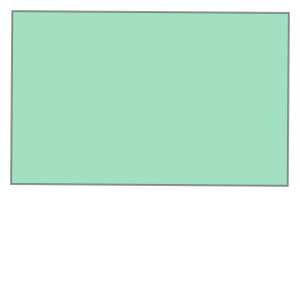

In [104]:
# Crop shapes outside of rectangles
transform(project, rectangle.geometry[0])

In [32]:
rectangle_area

99999.59972929955

In [106]:
# Function to calculate the shortest distance to roads
def calculate_minimum_distance_to_roads(building, road_union,utm_proj_rectangle):

    #nearest_geom = nearest_points(crs_transform(building), crs_transform(road_union))[1] #distance to closest road, given the input order
    nearest_geom = nearest_points(building, road_union)[1] #distance to closest road, given the input order
    return building.distance(nearest_geom)#degrees_to_meters(building.distance(nearest_geom), utm_proj_rectangle) 

# Apply the distance calculation to each building
buildings.loc[:,'distance_to_road'] = buildings['geometry'].apply(lambda x: x.centroid).apply(calculate_minimum_distance_to_roads, road_union=road_union, utm_proj_rectangle=utm_proj_rectangle)


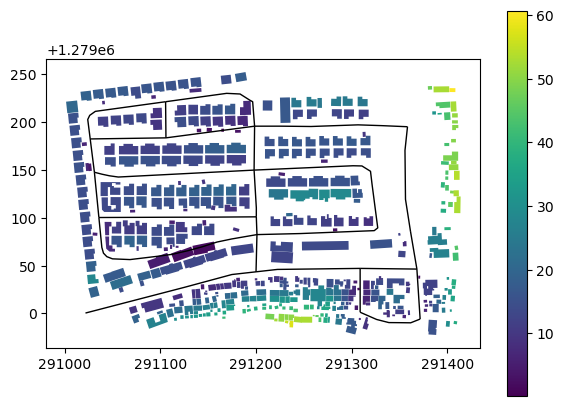

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
buildings.plot(column='distance_to_road', ax=ax, legend=True, cmap='viridis')
#roads_clipped = roads.clip(rectangle['geometry'])
roads.plot(ax=ax, color='black', linewidth=1)
plt.show()


In [108]:
buildings['distance_to_road'].describe()

count    424.000000
mean      20.342373
std       12.540910
min        0.170147
25%       12.071597
50%       15.858875
75%       26.756828
max       60.626468
Name: distance_to_road, dtype: float64

In [ ]:
# Intersections

In [ ]:

# Block polygons

In [ ]:

# City block width

In [109]:
# Calculate measures
buildings['distance_to_road'].describe()

count    424.000000
mean      20.342373
std       12.540910
min        0.170147
25%       12.071597
50%       15.858875
75%       26.756828
max       60.626468
Name: distance_to_road, dtype: float64

In [110]:
#1 Share of building footprints that are less than 10-meters away from the nearest road

def metric_1_distance_less_than_10m(buildings):
    return 100.*((sum(buildings['distance_to_road']<=10))/len(buildings))

metric_1_distance_less_than_10m(buildings)

17.68867924528302

In [111]:
#2 Average distance of building footprint centroids to roads
def metric_2_average_distance_to_roads(buildings):
    return buildings['distance_to_road'].mean()

metric_2_average_distance_to_roads(buildings)


20.342373213761217

In [58]:
roads_rectangle

,u,v,key,lanes,highway,oneway,length,geometry


In [112]:
#3 Density of roads
def metric_3_road_density(roads_rectangle,rectangle_area):
    #meter_length = degrees_to_meters(road_union.length,utm_zone_rectangle=utm_zone_rectangle)
    km_length = roads_rectangle.length.sum()/1000.
    rectangle_area_km2 = rectangle_area/1000000.
    return km_length/rectangle_area_km2

metric_3_road_density(roads_rectangle,rectangle_area)

23.155190110468748

In [113]:
#9 Tortuosity index
OSM_intersections

,osmid,y,x,street_count,geometry
0,1804671805,11.564050,43.086819,4,POINT (43.08682 11.56405)
1,5801455408,11.563578,43.086853,4,POINT (43.08685 11.56358)
2,5801455412,11.563638,43.086278,3,POINT (43.08628 11.56364)
3,5803782652,11.564053,43.086275,3,POINT (43.08627 11.56405)
4,5803790225,11.564409,43.086755,3,POINT (43.08675 11.56441)
5,5803875304,11.565275,43.084404,3,POINT (43.08440 11.56527)
6,5803875305,11.565617,43.084398,3,POINT (43.08440 11.56562)
7,5803875321,11.564534,43.085276,3,POINT (43.08528 11.56453)
8,5803875322,11.564517,43.083766,3,POINT (43.08377 11.56452)
9,5803875326,11.565391,43.085253,4,POINT (43.08525 11.56539)


In [120]:
OSM_intersections.street_count.value_counts()

street_count
3    12
4     5
Name: count, dtype: int64

In [121]:
#4 Share of 3-way and 4-way intersections 
def metric_4_share_3_and_4way_intersections(intersections):
    n_intersections_3_and_4 = 1.*len(intersections[(intersections.street_count == 4)|(intersections.street_count == 3)])
    n_4_way = 1.*len(intersections[(intersections.street_count == 4)])
    return (n_4_way / n_intersections_3_and_4)

metric_4_share_3_and_4way_intersections(OSM_intersections)

0.29411764705882354

In [122]:
#5 Number of 4-way intersections
def metric_5_4way_intersections(intersections):
    return 1.*len(intersections[(intersections.street_count == 4)])
metric_5_4way_intersections(OSM_intersections)

5.0

In [ ]:
buildings['geometry'].iloc[7].exterior.coords[0]

In [315]:
#6 Average building footprint orientation of the tile

def longest_segment(polygon):
    # Ensure the input is a valid Polygon
    if not isinstance(polygon, Polygon):
        raise TypeError("The input must be a shapely Polygon object.")
    
    # Get the exterior coordinates of the polygon
    exterior_coords = polygon.exterior.coords
    
    # Initialize variables to track the longest segment
    max_length = 0
    longest_segment = None
    
    # Iterate through the exterior coordinates to find the longest segment
    for i in range(len(exterior_coords) - 1):
        # Create a line segment from consecutive coordinates
        segment = LineString([exterior_coords[i], exterior_coords[i+1]])
        
        # Calculate the length of the segment
        segment_length = segment.length
        
        # Update the longest segment if this one is longer
        if segment_length > max_length:
            max_length = segment_length
            longest_segment = segment
    
    return longest_segment

#longest_seg = longest_segment(polygon)



def calculate_azimuth(segment):
    # Extract start and end points of the segment
    start_point = segment.coords[0]
    end_point = segment.coords[1]
    
    # Calculate the difference in coordinates
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]
    
    # Calculate the azimuth in radians
    azimuth_rad = math.atan2(delta_x, delta_y)
    
    # Convert the azimuth to degrees
    azimuth_deg = math.degrees(azimuth_rad)
    
    # Normalize the azimuth to be within 0 to 360 degrees
    #if azimuth_deg < 0:
    #    azimuth_deg += 360
    
    return np.abs(azimuth_deg)

# Assuming you have the longest segment from the previous example
#azimuth = calculate_azimuth(longest_seg)

buildings.loc[:,'azimuth'] = buildings['geometry'].apply(lambda x: calculate_azimuth(longest_segment(x)))

def metric_6_deviation_of_building_azimuth(buildings):
    return buildings.azimuth.std()/180.

print(metric_6_deviation_of_building_azimuth(buildings))
buildings.azimuth.describe()

0.323289127696127


count    424.000000
mean      88.431012
std       58.192043
min        0.008704
25%       75.217636
50%       89.847769
75%       96.411192
max      179.956446
Name: azimuth, dtype: float64

In [219]:
# Function to calculate the angle between two vectors
def calculate_angle(vector1, vector2):
    angle = np.arctan2(vector2[1], vector2[0]) - np.arctan2(vector1[1], vector1[0])
    angle = np.degrees(angle)
    if angle < 0:
        angle += 360
    return angle

def calculate_sequential_angles(intersections, roads):
    records = []  # List to store angle records
    
    # Iterate through each intersection
    for _, intersection in intersections.iterrows():
        intersection_id = intersection['osmid']
        intersection_point = intersection.geometry
        
        # Get all roads connected to the intersection
        connected_roads = roads[(roads['u'] == intersection_id) | (roads['v'] == intersection_id)]
        vectors = []
        
        for _, road in connected_roads.iterrows():
            coords = list(road.geometry.coords)
            
            # Determine the vector for the road segment away from the intersection
            if road['u'] == intersection_id:
                vector = (coords[1][0] - coords[0][0], coords[1][1] - coords[0][1])
            else:
                vector = (coords[-2][0] - coords[-1][0], coords[-2][1] - coords[-1][1])
            
            vectors.append((vector, road['u'], road['v']))
        
        # Sort vectors based on the angle relative to a fixed axis (e.g., x-axis)
        vectors.sort(key=lambda v: np.arctan2(v[0][1], v[0][0]))

        # Calculate the sequential angles between each pair of vectors
        for i in range(len(vectors)):
            vector1 = vectors[i][0]
            vector2 = vectors[(i + 1) % len(vectors)][0]  # Next vector, looping back to the start
            angle = calculate_angle(vector1, vector2)
            
            record = {
                'Intersection ID': intersection_id,
                'Segment 1': (vectors[i][1], vectors[i][2]),
                'Segment 2': (vectors[(i + 1) % len(vectors)][1], vectors[(i + 1) % len(vectors)][2]),
                'Angle': angle
            }
            records.append(record)
    
    # Create a DataFrame from the records
    df_angles = pd.DataFrame(records)
    
    return df_angles

,Intersection ID,Segment 1,Segment 2,Angle
0,1804671805,"(1804671805, 5801455408)","(1804671805, 5803790225)",185.995370
1,1804671805,"(1804671805, 5803790225)","(1804671805, 5803782652)",79.557924
2,1804671805,"(1804671805, 5803782652)","(1804671805, 5801455408)",94.446706


In [316]:
#10 Average angle between road segments
def metric_10_average_angle_between_road_segments(df_angles,OSM_intersections):
    intersection_angles_df = OSM_intersections[['osmid','street_count']].set_index('osmid').merge(df_angles.set_index('Intersection ID'),left_index=True,right_index=True,how='outer')

    # In 3-way intersections, include only the smallest angle in the tile average. 
    df_3_way = intersection_angles_df[(intersection_angles_df.street_count==3)]
    to_keep_3 = df_3_way.reset_index().loc[(df_3_way.reset_index().groupby(df_3_way.index)['Angle'].idxmin())].set_index('index')

    # In 4-way intersections, include only the two smallest angles in the tile average.
    df_4_way = intersection_angles_df[intersection_angles_df.street_count==4]
    to_keep_4 = df_4_way.groupby(df_4_way.index).apply(lambda x: x.nsmallest(2, 'Angle')).reset_index().set_index('level_0')
    to_keep_4.index.names = ['index']

    return pd.concat([to_keep_3,to_keep_4])['Angle'].mean()
    
df_angles = calculate_sequential_angles(OSM_intersections, OSM_roads)
metric_10_average_angle_between_road_segments(df_angles=df_angles,OSM_intersections=OSM_intersections)

95.3316544146075

In [ ]:
# Get blocks

# Get largest circle inscribed in block

In [317]:
type(OSM_roads)

geopandas.geodataframe.GeoDataFrame

In [ ]:
#7 Average block width


In [ ]:
#8 Share of footprints intersected by equidistant line or equivalent segment